In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd

# Function to convert a date to a UNIX timestamp at midnight UTC
def date_to_unix_midnight(date_str):
    return int(datetime.strptime(date_str, '%Y-%m-%d').replace(hour=0, minute=0, second=0).timestamp())

# Function to retrieve arrival and departure data
def get_flights(airport, begin, end):
    arrivals_url = "https://opensky-network.org/api/flights/arrival"
    departures_url = "https://opensky-network.org/api/flights/departure"
    
  # Retrieve arrivals
    arrivals_params = {'airport': airport, 'begin': begin, 'end': end}
    arrivals_response = requests.get(arrivals_url, params=arrivals_params)
    if arrivals_response.status_code == 200:
        arrivals = arrivals_response.json()
    else:
        print(f"Error for Retrieving arrivals : {arrivals_response.status_code} - {arrivals_response.text}")
        arrivals = []
    
    # Retrieve departures
    departures_params = {'airport': airport, 'begin': begin, 'end': end}
    departures_response = requests.get(departures_url, params=departures_params)
    if departures_response.status_code == 200:
        departures = departures_response.json()
    else:
        print(f"Error retrieving departures: {departures_response.status_code} - {departures_response.text}")
        departures = []
    
    return arrivals, departures

# Function to retrieve data for a 30 day period in 7 day segments
def get_flights_for_30_days(airport, start_date, end_date):
    current_start = start_date
    all_arrivals = []
    all_departures = []

    while current_start < end_date:
        current_end = min(current_start + timedelta(days=7), end_date)  # Limit on max 7 days
        
        begin = int(current_start.timestamp())
        end = int(current_end.timestamp())
        
        print(f"Data recovery from {current_start} to {current_end}")
        
        # Retrieve arrivals and departures data for the period
        arrivals, departures = get_flights(airport, begin, end)
        all_arrivals.extend(arrivals)
        all_departures.extend(departures)
        
      # Move to the next period
        current_start = current_end

    return all_arrivals, all_departures

# Set the period (January 1 to January 30, 2023)
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 1, 30)
airport = 'KJFK'

arrivals, departures = get_flights_for_30_days(airport, start_date, end_date)

# Show results
print(f"Arrivals : {len(arrivals)}flights recovered")
print(f"Départures : {len(departures)} flights recovered")

# Convert to DataFrame and save as CSV
arrivals_df = pd.DataFrame(arrivals)
departures_df = pd.DataFrame(departures)

arrivals_df.to_csv('arrivals_jan2023.csv', index=False)
departures_df.to_csv('departures_jan2023.csv', index=False)


In [15]:
from datetime import datetime, timedelta
import requests
import pandas as pd

#Read CSV File
arrivals_df = pd.read_csv('arrivals_jan2023.csv')
departures_df = pd.read_csv('departures_jan2023.csv')
print(arrivals_df.head())
print ()


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490                 NaN  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133                 NaN  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                                NaN   
2  QTR8183                              742.0   
3  JBU1110                                NaN   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                              NaN                            2869   
2                            121.0          

In [16]:
print(departures_df.head())

   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  aaaa92  1673153994                KJFK  1673189757              LLBG   
1  a4ce71  1673153643                KJFK  1673188364              LLBG   
2  adde95  1673153344                KJFK  1673171664              KSAN   
3  a721a4  1673152880                KJFK  1673159397               NaN   
4  06a1d3  1673152733                KJFK  1673194534              OMDW   

   callsign  estDepartureAirportHorizDistance  \
0  AAL146                                2427   
1  DAL234                                2264   
2  JBU89                                 2516   
3  JBU1359                               2226   
4  QQE942                                1734   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                               72                          4015.0   
1                              102                          3858.0   
2                               72          

In [90]:
# Get data size
arrivals_shape = arrivals_df.shape
departures_shape = departures_df.shape

print(f"Size of arrival data: {arrivals_shape}")
print(f"Size of departure date : {departures_shape}")

Size of arrival data: (16614, 12)
Size of departure date : (15898, 12)


In [91]:

# STEP 2: Data cleaning
# Identifying missing values
print("Missing values ​​in arrivals data:")
print(arrivals_df.isnull().sum())

print("\nMissing values ​​in the starting data :")
print(departures_df.isnull().sum())

#1. Remove lines with missing 'callsign'
arrivals_df_clean = arrivals_df.dropna(subset=['callsign']).copy()
departures_df_clean = departures_df.dropna(subset=['callsign']).copy()

#2. Fill the 'estDepartureAirport' and 'estArrivalAirport' columns with 'Unknown'
arrivals_df_clean.loc[:, 'estDepartureAirport'] = arrivals_df_clean['estDepartureAirport'].fillna('Unknown')
departures_df_clean.loc[:, 'estArrivalAirport'] = departures_df_clean['estArrivalAirport'].fillna('Unknown')

#3. Imputation of missing distances with the median
arrivals_df_clean.loc[:, 'estDepartureAirportHorizDistance'] = arrivals_df_clean['estDepartureAirportHorizDistance'].fillna(arrivals_df_clean['estDepartureAirportHorizDistance'].median())
arrivals_df_clean.loc[:, 'estDepartureAirportVertDistance'] = arrivals_df_clean['estDepartureAirportVertDistance'].fillna(arrivals_df_clean['estDepartureAirportVertDistance'].median())

departures_df_clean.loc[:, 'estArrivalAirportHorizDistance'] = departures_df_clean['estArrivalAirportHorizDistance'].fillna(departures_df_clean['estArrivalAirportHorizDistance'].median())
departures_df_clean.loc[:, 'estArrivalAirportVertDistance'] = departures_df_clean['estArrivalAirportVertDistance'].fillna(departures_df_clean['estArrivalAirportVertDistance'].median())

#4. Checking for missing values ​​after cleaning
print("\nMissing values ​​remaining after cleaning (arrivals):")
print(arrivals_df_clean.isnull().sum())

print("\nMissing values ​​remaining after cleaning (départures) :")
print(departures_df_clean.isnull().sum())

# Save cleaned data to CSV files
arrivals_df_clean.to_csv('arrivals_jan2023_clean.csv', index=False)
departures_df_clean.to_csv('departures_jan2023_clean.csv', index=False)
print("\Cleaned data saved successfully.")


Missing values ​​in arrivals data:
icao24                                 0
firstSeen                              0
estDepartureAirport                 3370
lastSeen                               0
estArrivalAirport                      0
callsign                               3
estDepartureAirportHorizDistance    3370
estDepartureAirportVertDistance     3370
estArrivalAirportHorizDistance         0
estArrivalAirportVertDistance          0
departureAirportCandidatesCount        0
arrivalAirportCandidatesCount          0
dtype: int64

Missing values ​​in the starting data :
icao24                                 0
firstSeen                              0
estDepartureAirport                    0
lastSeen                               0
estArrivalAirport                   2121
callsign                               3
estDepartureAirportHorizDistance       0
estDepartureAirportVertDistance        0
estArrivalAirportHorizDistance      2121
estArrivalAirportVertDistance       2121
departure

<>:34: SyntaxWarning: invalid escape sequence '\C'
<>:34: SyntaxWarning: invalid escape sequence '\C'
C:\Users\olive\AppData\Local\Temp\ipykernel_37896\2688025459.py:34: SyntaxWarning: invalid escape sequence '\C'
  print("\Cleaned data saved successfully.")


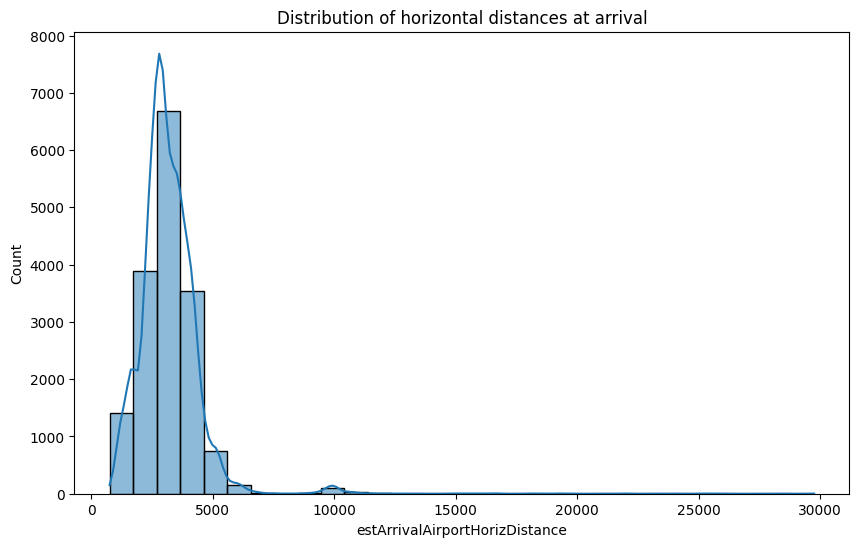

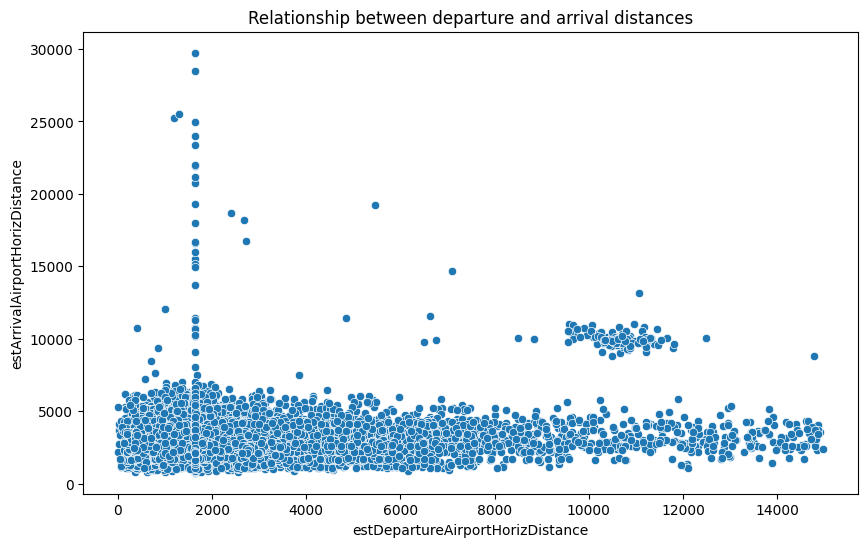

In [92]:
# EDA 

import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of arrival distances
plt.figure(figsize=(10,6))
sns.histplot(arrivals_df_clean['estArrivalAirportHorizDistance'], bins=30, kde=True)
plt.title('Distribution of horizontal distances at arrival')
plt.show()

# Scatter plot of start and finish distances
plt.figure(figsize=(10,6))
sns.scatterplot(x='estDepartureAirportHorizDistance', y='estArrivalAirportHorizDistance', data=arrivals_df_clean)
plt.title('Relationship between departure and arrival distances')
plt.show()


In [20]:
#Feature engineering

# Calculate the flight time in seconds
arrivals_df_clean['flight_duration'] = arrivals_df_clean['lastSeen'] - arrivals_df_clean['firstSeen']
departures_df_clean['flight_duration'] = departures_df_clean['lastSeen'] - departures_df_clean['firstSeen']

# Converting timestamps to days of the week
arrivals_df_clean['weekday'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.weekday
departures_df_clean['weekday'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.weekday
# Set a threshold to consider a flight delayed (e.g. median)
flight_duration_threshold = arrivals_df_clean['flight_duration'].median()

# Create a column 'delayed' where True indicates a delay (flight longer than the median)
arrivals_df_clean['delayed'] = arrivals_df_clean['flight_duration'] > flight_duration_threshold

# Check new columns
print(arrivals_df_clean[['flight_duration', 'delayed']].head())

   flight_duration  delayed
0            14893     True
1            17359     True
2            27093     True
3            12360     True
4            17168     True


In [23]:
# Create a new feature for the difference between the start and finish distances
arrivals_df_clean['distance_diff'] = arrivals_df_clean['estArrivalAirportHorizDistance'] - arrivals_df_clean['estDepartureAirportHorizDistance']

# Extract time of day from timestamp 'firstSeen'
arrivals_df_clean['hour_of_day'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.hour

# Create an interaction between 'hour_of_day' and 'weekday'
arrivals_df_clean['hour_weekday_interaction'] = arrivals_df_clean['hour_of_day'] * arrivals_df_clean['weekday']

# Check new columns
print(arrivals_df_clean[['distance_diff', 'hour_of_day', 'hour_weekday_interaction']].head())

   distance_diff  hour_of_day  hour_weekday_interaction
0        -2154.0            0                         0
1         1242.0            0                         0
2         1997.0           21                       105
3         2108.0            1                         6
4          407.0            0                         0


In [25]:
# ADD ANOTHER DATA 

import requests

# Visual Crossing API Key
api_key = 'AMZW2KNXFLDJF9R5WMUTHMWHQ'

# Location
location = 'Paris,France'

# 1 month period (from January 1, 2023 to January 30, 2023)
start_date = '2023-01-01'
end_date = '2023-01-30'

# Visual Crossing API URL for a time period
url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}?key={api_key}"

# Make the query to retrieve the weather data
response = requests.get(url)

# Verifying the response
if response.status_code == 200:
    data = response.json()
    print("Données récupérées avec succès")
    

  # show first entries
    for day in data['days']:
        print(f"Date: {day['datetime']}, Température max: {day['tempmax']}°C, Température min: {day['tempmin']}°C")
else:
    print(f"Erreur {response.status_code}: {response.text}")


Données récupérées avec succès
Date: 2023-01-01, Température max: 58.8°C, Température min: 52.5°C
Date: 2023-01-02, Température max: 57.6°C, Température min: 45.1°C
Date: 2023-01-03, Température max: 49.2°C, Température min: 42.0°C
Date: 2023-01-04, Température max: 56.3°C, Température min: 49.6°C
Date: 2023-01-05, Température max: 56.5°C, Température min: 52.4°C
Date: 2023-01-06, Température max: 55.7°C, Température min: 50.7°C
Date: 2023-01-07, Température max: 51.7°C, Température min: 45.7°C
Date: 2023-01-08, Température max: 51.7°C, Température min: 44.9°C
Date: 2023-01-09, Température max: 48.2°C, Température min: 42.3°C
Date: 2023-01-10, Température max: 52.8°C, Température min: 39.5°C
Date: 2023-01-11, Température max: 53.7°C, Température min: 49.0°C
Date: 2023-01-12, Température max: 53.0°C, Température min: 48.6°C
Date: 2023-01-13, Température max: 52.1°C, Température min: 45.6°C
Date: 2023-01-14, Température max: 54.1°C, Température min: 46.1°C
Date: 2023-01-15, Température m

In [26]:


# Convert weather data to pandas DataFrame
weather_data = pd.DataFrame(data['days'])
# Save data to a CSV file
weather_data.to_csv('weather_data_1mois.csv', index=False)
print("Weather data saved in 'weather_data_1mois.csv'")

Données météo sauvegardées dans 'weather_data_1mois.csv'


In [27]:
print(weather_data.head())

     datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2023-01-01     1672527600     58.8     52.5  55.5          58.8   
1  2023-01-02     1672614000     57.6     45.1  51.3          57.6   
2  2023-01-03     1672700400     49.2     42.0  45.7          45.0   
3  2023-01-04     1672786800     56.3     49.6  53.1          56.3   
4  2023-01-05     1672873200     56.5     52.4  54.6          56.5   

   feelslikemin  feelslike   dew  humidity  ...  sunriseEpoch    sunset  \
0          52.5       55.5  47.2      74.5  ...    1672559053  17:04:11   
1          42.0       50.6  46.7      84.7  ...    1672645450  17:05:11   
2          38.7       41.6  43.6      92.4  ...    1672731845  17:06:13   
3          44.4       52.6  50.3      90.4  ...    1672818236  17:07:17   
4          52.4       54.6  50.1      84.9  ...    1672904624  17:08:24   

   sunsetEpoch moonphase              conditions  \
0   1672589051      0.31          Rain, Overcast   
1   1672675511      0.35

In [28]:
# Fahrenheit -> Celsius conversion function
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5.0/9.0
# Converting temperature columns to Celsius
weather_data['tempmax'] = weather_data['tempmax'].apply(fahrenheit_to_celsius)
weather_data['tempmin'] = weather_data['tempmin'].apply(fahrenheit_to_celsius)
weather_data['temp'] = weather_data['temp'].apply(fahrenheit_to_celsius)

# Check for changes
print(weather_data[['datetime', 'tempmax', 'tempmin', 'temp']].head())


     datetime    tempmax    tempmin       temp
0  2023-01-01  14.888889  11.388889  13.055556
1  2023-01-02  14.222222   7.277778  10.722222
2  2023-01-03   9.555556   5.555556   7.611111
3  2023-01-04  13.500000   9.777778  11.722222
4  2023-01-05  13.611111  11.333333  12.555556


In [29]:
# Select relevant columns
columns_to_keep = ['datetime', 'tempmax', 'tempmin', 'humidity', 'conditions', 'description']
selected_weather_data = weather_data[columns_to_keep]
# Show selected data
print(selected_weather_data.head())


# Save selected data to a CSV file
selected_weather_data.to_csv('selected_weather_data.csv', index=False)
print("Selected weather data saved in 'selected_weather_data.csv'")


     datetime    tempmax    tempmin  humidity              conditions  \
0  2023-01-01  14.888889  11.388889      74.5          Rain, Overcast   
1  2023-01-02  14.222222   7.277778      84.7  Rain, Partially cloudy   
2  2023-01-03   9.555556   5.555556      92.4  Rain, Partially cloudy   
3  2023-01-04  13.500000   9.777778      90.4          Rain, Overcast   
4  2023-01-05  13.611111  11.333333      84.9          Rain, Overcast   

                                         description  
0  Cloudy skies throughout the day with afternoon...  
1  Partly cloudy throughout the day with a chance...  
2        Partly cloudy throughout the day with rain.  
3         Cloudy skies throughout the day with rain.  
4         Cloudy skies throughout the day with rain.  
Données météo sélectionnées sauvegardées dans 'selected_weather_data.csv'


In [30]:
# DATA MERGE

# Load cleaned flight data (arrivals and departures)
arrivals_df_clean = pd.read_csv('arrivals_jan2023_clean.csv')
departures_df_clean = pd.read_csv('departures_jan2023_clean.csv')
# Load cleaned weather data
weather_data = pd.read_csv('selected_weather_data.csv')

# Associate arrival or departure date with weather data
# Here we use the 'datetime' column in weather_data and 'lastSeen' in arrivals_df_clean (or 'firstSeen' for departures)

# Convert date columns to the same format
arrivals_df_clean['date'] = pd.to_datetime(arrivals_df_clean['lastSeen'], unit='s').dt.date
departures_df_clean['date'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.date
weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date

# Merge weather data with arrivals and departures data
arrivals_with_weather = pd.merge(arrivals_df_clean, weather_data, left_on='date', right_on='datetime', how='left')
departures_with_weather = pd.merge(departures_df_clean, weather_data, left_on='date', right_on='datetime', how='left')

# Show some results to check
print(arrivals_with_weather.head())
print(departures_with_weather.head())

# Save results to CSV files
arrivals_with_weather.to_csv('arrivals_with_weather.csv', index=False)
departures_with_weather.to_csv('departures_with_weather.csv', index=False)

print("Flight data with associated weather saved.")


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490             Unknown  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133             Unknown  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                             1627.0   
2  QTR8183                              742.0   
3  JBU1110                             1627.0   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                            133.0                            2869   
2                            121.0          

In [94]:

# Get data size
arrivals_shape = arrivals_with_weather.shape
departures_shape = departures_with_weather.shape

print(f"Size of arrival data : {arrivals_shape}")
print(f"Size of departure data : {departures_shape}")


Size of arrival data : (16611, 19)
Size of departure data : (15895, 19)


In [32]:

# Load flight data with associated weather
arrivals_with_weather = pd.read_csv('arrivals_with_weather.csv')
departures_with_weather = pd.read_csv('departures_with_weather.csv')

# Fill missing values ​​with an interpolation method or default values
arrivals_with_weather.fillna(method='ffill', inplace=True) 
departures_with_weather.fillna(method='ffill', inplace=True)



# Show a preview of the results to check
print(arrivals_with_weather.head())
print(departures_with_weather.head())

#Save files after handling missing values
arrivals_with_weather.to_csv('arrivals_with_weather_cleaned.csv', index=False)
departures_with_weather.to_csv('departures_with_weather_cleaned.csv', index=False)

print("Cleaned flight data with associated weather saved.")


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490             Unknown  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133             Unknown  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                             1627.0   
2  QTR8183                              742.0   
3  JBU1110                             1627.0   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                            133.0                            2869   
2                            121.0          

C:\Users\olive\AppData\Local\Temp\ipykernel_37896\258920381.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arrivals_with_weather.fillna(method='ffill', inplace=True)  # Utiliser les valeurs précédentes
C:\Users\olive\AppData\Local\Temp\ipykernel_37896\258920381.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  departures_with_weather.fillna(method='ffill', inplace=True)


In [95]:
# View information from both DataFrames
print("\nArrival informations:")
print(arrivals_with_weather.info())


Arrival informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16611 entries, 0 to 16610
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   icao24                            16611 non-null  object 
 1   firstSeen                         16611 non-null  int64  
 2   estDepartureAirport               16611 non-null  object 
 3   lastSeen                          16611 non-null  int64  
 4   estArrivalAirport                 16611 non-null  object 
 5   callsign                          16611 non-null  object 
 6   estDepartureAirportHorizDistance  16611 non-null  float64
 7   estDepartureAirportVertDistance   16611 non-null  float64
 8   estArrivalAirportHorizDistance    16611 non-null  int64  
 9   estArrivalAirportVertDistance     16611 non-null  int64  
 10  departureAirportCandidatesCount   16611 non-null  int64  
 11  arrivalAirportCandidatesCount     16611 non-

In [96]:
print("\nDeparture informations:")
print(departures_with_weather.info())


Departure informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15895 entries, 0 to 15894
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   icao24                            15895 non-null  object 
 1   firstSeen                         15895 non-null  int64  
 2   estDepartureAirport               15895 non-null  object 
 3   lastSeen                          15895 non-null  int64  
 4   estArrivalAirport                 15895 non-null  object 
 5   callsign                          15895 non-null  object 
 6   estDepartureAirportHorizDistance  15895 non-null  int64  
 7   estDepartureAirportVertDistance   15895 non-null  int64  
 8   estArrivalAirportHorizDistance    15895 non-null  float64
 9   estArrivalAirportVertDistance     15895 non-null  float64
 10  departureAirportCandidatesCount   15895 non-null  int64  
 11  arrivalAirportCandidatesCount     15895 no

In [35]:
print(departures_with_weather.head())

print()

print(arrivals_with_weather.head())

   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  aaaa92  1673153994                KJFK  1673189757              LLBG   
1  a4ce71  1673153643                KJFK  1673188364              LLBG   
2  adde95  1673153344                KJFK  1673171664              KSAN   
3  a721a4  1673152880                KJFK  1673159397           Unknown   
4  06a1d3  1673152733                KJFK  1673194534              OMDW   

   callsign  estDepartureAirportHorizDistance  \
0  AAL146                                2427   
1  DAL234                                2264   
2  JBU89                                 2516   
3  JBU1359                               2226   
4  QQE942                                1734   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                               72                          4015.0   
1                              102                          3858.0   
2                               72          

In [97]:

# Merge the two DataFrames on a common column (eg: 'icao24')
merged_data = pd.merge(arrivals_with_weather, departures_with_weather, on='icao24', suffixes=('_arrival', '_departure'))

# Check the result
print("\nMerged data:")
print(merged_data.head())


Merged data:
   icao24  firstSeen_arrival estDepartureAirport_arrival  lastSeen_arrival  \
0  ac8217         1673138964                        KSLC        1673153857   
1  ac8217         1673138964                        KSLC        1673153857   
2  ac8217         1673138964                        KSLC        1673153857   
3  ac8217         1673138964                        KSLC        1673153857   
4  ac8217         1673138964                        KSLC        1673153857   

  estArrivalAirport_arrival callsign_arrival  \
0                      KJFK         DAL380     
1                      KJFK         DAL380     
2                      KJFK         DAL380     
3                      KJFK         DAL380     
4                      KJFK         DAL380     

   estDepartureAirportHorizDistance_arrival  \
0                                    3259.0   
1                                    3259.0   
2                                    3259.0   
3                                    325

In [37]:
# Save the merged file if you merged the data
merged_data.to_csv('merged_flight_data.csv', index=False)

In [38]:
# Check for duplicates
duplicates = merged_data.duplicated()
print(f"Number of duplicates : {duplicates.sum()}")

# Remove duplicates 
merged_data_clean = merged_data.drop_duplicates()

Nombre de doublons : 7945


In [44]:
# Create a copy of the original DataFrame
merged_data_clean = merged_data_clean.copy()

# Calculate flight duration using
merged_data_clean.loc[:, 'flight_duration'] = merged_data_clean['lastSeen_arrival'] - merged_data_clean['firstSeen_arrival']

# Replace missing values ​​with 0 explicitly
merged_data_clean.loc[:, 'flight_duration'] = merged_data_clean['flight_duration'].fillna(0)



In [46]:
# Converting timestamps to days of the week
merged_data_clean['weekday'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.weekday

# Set a threshold to consider a flight as delayed (e.g. the median)
flight_duration_threshold = merged_data_clean['flight_duration'].median()
# Create a column 'delayed' where True indicates a delay (flight longer than the median)
merged_data_clean['delayed'] = merged_data_clean['flight_duration'] > flight_duration_threshold

# Check new columns
print(merged_data_clean[['flight_duration', 'delayed']].head())

   flight_duration  delayed
0            14893     True
1            14893     True
2            14893     True
3            14893     True
4            14893     True


In [55]:
# Added weather features relevant to prediction
features = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival', 'conditions_arrival',
            'tempmax_departure', 'tempmin_departure', 'humidity_departure', 'conditions_departure',
            'flight_duration', 'weekday']
# Data preparation for modeling
X = merged_data_clean[features]
y = merged_data_clean['delayed']  # Target: if the flight is delayed
# Display the first lines of the processed data
print(merged_data_clean[['flight_duration', 'delayed', 'tempmax_arrival', 'tempmin_arrival', 'humidity_arrival']].head())

   flight_duration  delayed  tempmax_arrival  tempmin_arrival  \
0            14893     True        10.944444         7.166667   
1            14893     True        10.944444         7.166667   
2            14893     True        10.944444         7.166667   
3            14893     True        10.944444         7.166667   
4            14893     True        10.944444         7.166667   

   humidity_arrival  
0              83.1  
1              83.1  
2              83.1  
3              83.1  
4              83.1  


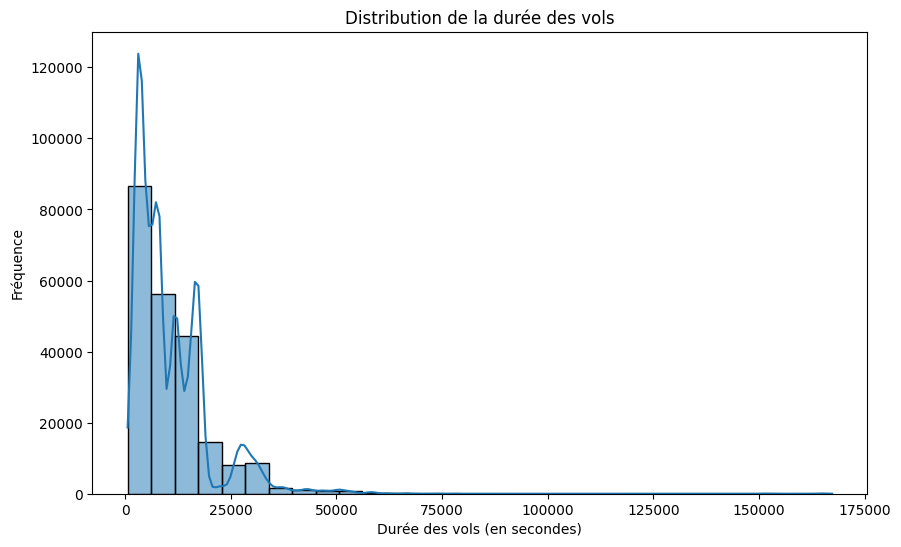

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of flight duration
plt.figure(figsize=(10, 6))
sns.histplot(merged_data_clean['flight_duration'], bins=30, kde=True)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (in seconds)')
plt.ylabel('Frequency')
plt.show()


delayed
False    111700
True     111682
Name: count, dtype: int64


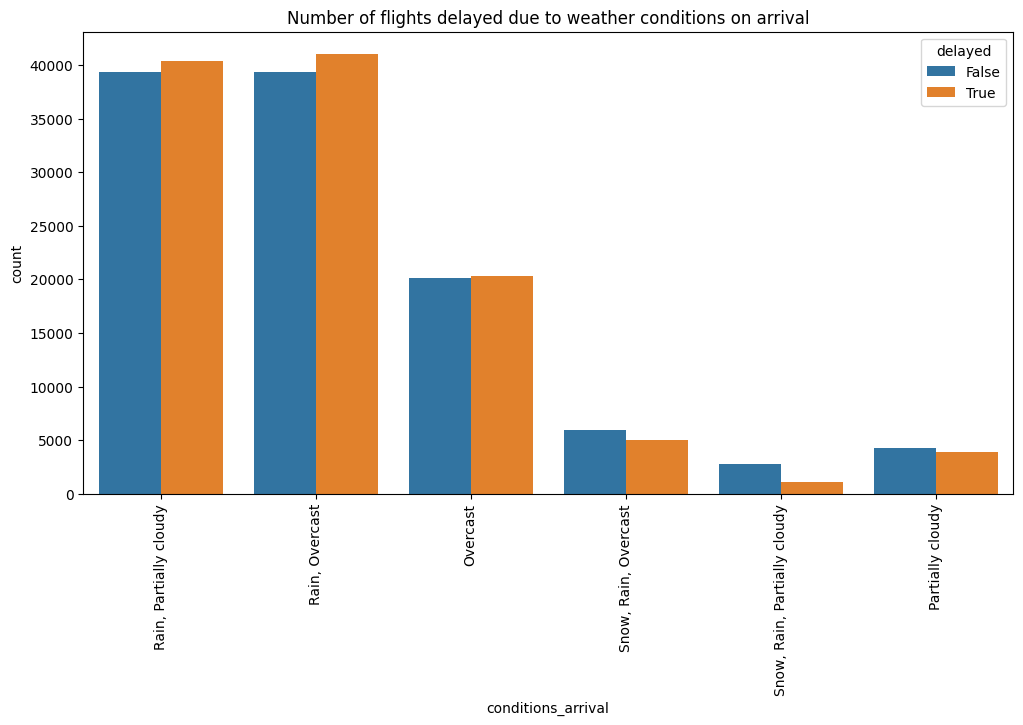

In [89]:
#ANALYSIS OF DELAYS

# Counting delayed and on-time flights
print(merged_data_clean['delayed'].value_counts())

# Graph of delays by weather condition
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_arrival', hue='delayed', data=merged_data_clean)
plt.xticks(rotation=90)
plt.title('Number of flights delayed due to weather conditions on arrival')
plt.show()


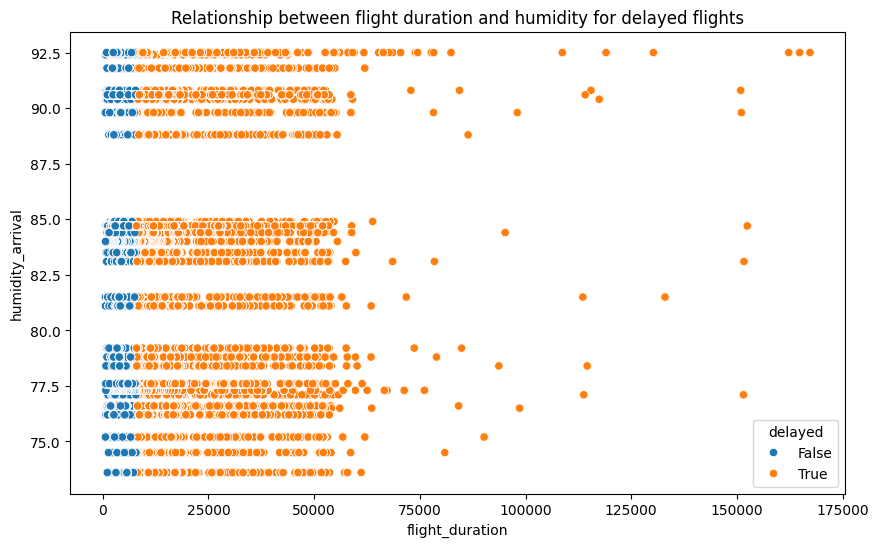

In [88]:
# ANALYSIS OF RELATIONSHIPS BETWEEN VARIABLES

# Scatter Chart: Flight Duration vs Delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='flight_duration', y='humidity_arrival', hue='delayed', data=merged_data_clean)
plt.title('Relationship between flight duration and humidity for delayed flights')
plt.show()

In [56]:
# MODEL

from sklearn.model_selection import train_test_split

# First divide into 80% (training + validation) and 20% (final test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then divide X_train_val again to get 70% for training and 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (156366, 10)
Validation size: (22339, 10)
Test size: (44677, 10)


In [57]:
# Save datasets to CSV files
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# Also save targets (y)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



In [103]:
# SVM MODEL

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# List of categorical columns to encode
categorical_columns = ['icao24', 'estDepartureAirport_arrival', 'estArrivalAirport_arrival', 
                       'callsign_arrival', 'estDepartureAirport_departure', 
                       'estArrivalAirport_departure', 'callsign_departure', 
                       'conditions_arrival', 'conditions_departure']

# Encode categorical columns with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
        X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Imputation of missing values
imputer = SimpleImputer(strategy='mean') # Replace NaN with column averages
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


#Data Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train.values.ravel())  # .ravel() to convert to 1D array

# Predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)


classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"SVM model accuracy: {accuracy * 100:.2f}%")
print ()
print("\nClassification report:")
print(classification_rep)


# SVM model save
joblib.dump(svm_model, 'svm_model_final.pkl')
joblib.dump(scaler, 'scaler_final.pkl')


SVM model accuracy: 98.93%


Classification report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22223
        True       0.99      0.99      0.99     22454

    accuracy                           0.99     44677
   macro avg       0.99      0.99      0.99     44677
weighted avg       0.99      0.99      0.99     44677



['scaler_final.pkl']

In [9]:
# Optimized SVM Model

import pandas as pd
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,  classification_report
import joblib

# Load Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# List of categorical columns to encode
categorical_columns = ['icao24', 'estDepartureAirport_arrival', 'estArrivalAirport_arrival', 
                       'callsign_arrival', 'estDepartureAirport_departure', 
                       'estArrivalAirport_departure', 'callsign_departure', 
                       'conditions_arrival', 'conditions_departure']

# Encode categorical columns with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
        X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Imputation of missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Define a hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Create a basic SVM model
svm_model = SVC()

# Perform a grid search with cross-validation to optimize SVM
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Best hyperparameters for SVM
best_svm_model = grid_search.best_estimator_

# Save the optimized SVM model
joblib.dump(best_svm_model, 'optimized_svm_model.pkl')

# Predictions with the optimized model
y_pred_optimized = best_svm_model.predict(X_test_scaled)


classification_rep = classification_report(y_test, y_pred_optimized)

# Evaluation of the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy of the SVM model after optimization: {accuracy_optimized * 100:.2f}%")
print()

print("\nClassification report:")
print(classification_rep)




Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of the SVM model after optimization: 99.93%


Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22223
        True       1.00      1.00      1.00     22454

    accuracy                           1.00     44677
   macro avg       1.00      1.00      1.00     44677
weighted avg       1.00      1.00      1.00     44677



In [81]:
# LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Load the saved datasets
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure that y_train and y_test are converted to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Identify categorical columns
categorical_columns = ['conditions_arrival', 'conditions_departure']  # Add other categorical columns if needed

# Encode the categorical columns with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Impute missing values (if necessary)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
logreg_model = LogisticRegression(max_iter=500)
logreg_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = logreg_model.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy of logistic regression model: {accuracy * 100:.2f}%")
print("\nClassification report:")
print(classification_rep)


Accuracy of logistic regression model: 99.93%

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22223
        True       1.00      1.00      1.00     22454

    accuracy                           1.00     44677
   macro avg       1.00      1.00      1.00     44677
weighted avg       1.00      1.00      1.00     44677



In [87]:

# Save the logistic regression model
joblib.dump(logreg_model, 'logistic regression model_.pkl')
print("logistic regression model was saved successfully.")

logistic regression model was saved successfully.


In [78]:
# KNN CLASSIFIER

from sklearn.neighbors import KNeighborsClassifier

# Load Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Identify numeric and categorical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Impute numeric columns with average
numerical_imputer = SimpleImputer(strategy='mean')
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

# Impute categorical columns with most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

#Encode categorical columns with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Data scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train.values.ravel())

# Predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of KNN model : {accuracy * 100:.2f}%")
print()

print("classification_report")
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)




Accuracy of KNN model : 99.01%

classification_report
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22223
        True       0.99      0.99      0.99     22454

    accuracy                           0.99     44677
   macro avg       0.99      0.99      0.99     44677
weighted avg       0.99      0.99      0.99     44677



In [84]:

# Save the KNN model to a file
joblib.dump(knn_model, 'Final_KNN_model.pkl')

print("KNN model was saved successfully.")


KNN model was saved successfully.


In [11]:
# Stacking model with SVM OPTIMIZE

import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')


# Ensure that y_train and y_test are converted to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# List of categorical columns to encode
categorical_columns = ['icao24', 'estDepartureAirport_arrival', 'estArrivalAirport_arrival', 
                       'callsign_arrival', 'estDepartureAirport_departure', 
                       'estArrivalAirport_departure', 'callsign_departure', 
                       'conditions_arrival', 'conditions_departure']

# Encode categorical columns with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
        X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Imputation of missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Load the optimized SVM model
best_svm_model = joblib.load('optimized_svm_model.pkl')

# Base models for stacking
knn_model = KNeighborsClassifier(n_neighbors=5)
logreg_model = LogisticRegression(max_iter=500)

# Final model for stacking (meta-learner)
meta_learner = LogisticRegression(max_iter=500)

# Create a stacking classifier using the optimized SVM
stacking_model = StackingClassifier(
    estimators=[('svm', best_svm_model), ('knn', knn_model), ('logreg', logreg_model)],
    final_estimator=meta_learner
)

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train)

# Save the stacking model
joblib.dump(stacking_model, 'stacking_model.pkl')

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
classification_rep_stack = classification_report(y_test, y_pred_stack)

print(f"Accuracy of the stacking model: {accuracy_stack * 100:.2f}%")
print("\nClassification report:")
print(classification_rep_stack)


Accuracy of the stacking model: 99.94%

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22223
        True       1.00      1.00      1.00     22454

    accuracy                           1.00     44677
   macro avg       1.00      1.00      1.00     44677
weighted avg       1.00      1.00      1.00     44677

